In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)


import paragami

# BNP sensitivity libraries
import sys
sys.path.insert(0, '../libraries/')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

/home/runjing_liu/Documents/BNP/autograd/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

In [3]:
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    n_obs = len(iris_species)    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 5
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.6)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')
        
    iris_species = np.argmax(true_z, axis = 1)

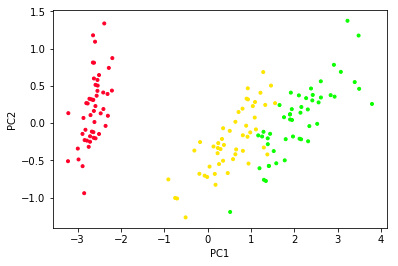

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [7]:
k_approx = 12

In [8]:
# Gauss-Hermite points
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)


In [9]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [10]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1268.0500184563955

# Optimize

### Kmeans

In [11]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init)

In [12]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


### Newton

In [14]:
vb_opt = gmm_lib.optimize_full(features, vb_params_paragami, prior_params_dict,
                    init_vb_free_params, gh_loc, gh_weights,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -315.152522
         Iterations: 381
         Function evaluations: 471
         Gradient evaluations: 459

 running preconditioned newton; iter =  0
Optimization terminated successfully.
         Current function value: -315.152522
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
Iter 0: x_diff = 3.0279349852123643e-06, f_diff = 1.4210854715202004e-12, grad_l1 = 7.2345138405708715e-12
done. 


In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

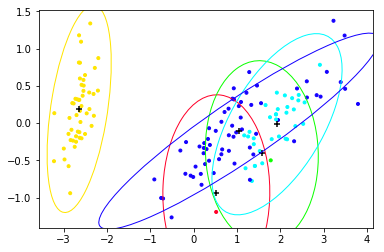

In [17]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Define a perturbation in the logit v space.

In [18]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.
phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [18]:
prior_perturbation = fun_sens_lib.PriorPerturbation(vb_params_dict = vb_opt_dict, 
                                                    alpha0 = prior_params_dict['alpha'],
                                                    gh_loc = gh_loc, 
                                                    gh_weights = gh_weights, 
                                                    log_phi = log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-1.0986122886681098 -3.514765556406881 -1.0996184973479006 -3.513759222447598


phi max:  0.4997727846542519


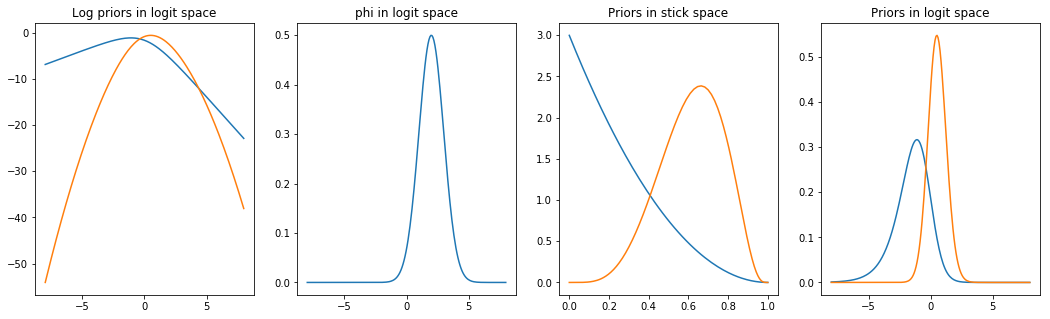

In [19]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [15]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

NameError: name 'prior_perturbation' is not defined

# Define prior perturbation

In [23]:
epsilon_param_dict = {'epsilon': np.array([1.0])}

epsilon_param_paragami = paragami.PatternDict() 
epsilon_param_paragami['epsilon'] = \
        paragami.NumericArrayPattern(shape=(1, ), lb = 0.0, ub = 1.0)

In [25]:
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon_param_dict, 
                           gh_loc, gh_weights, sum_vector=True):
    perturbation_fun = \
        lambda logit_v: log_phi(logit_v) * epsilon_param_dict['epsilon']

    e_perturbation_vec = modeling_lib.get_e_func_logit_stick_vec(
        vb_params_dict, gh_loc, gh_weights, perturbation_fun)

    if sum_vector:
        return -1 * np.sum(e_perturbation_vec)
    else:
        return -1 * e_perturbation_vec


In [26]:
def get_perturbed_kl(y, vb_params_dict, epsilon_param_dict, log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation): 
    
    e_log_pert = get_e_log_perturbation(log_phi, vb_params_dict, epsilon_param_dict, 
                           gh_loc, gh_weights, sum_vector=True)

    return gmm_lib.get_kl(y, vb_params_dict, prior_params_dict, gh_loc, gh_weights) + e_log_pert

In [27]:
# we will use this for the sensitivity class
get_epsilon_vb_loss = paragami.Functor(
    original_fun=get_perturbed_kl, argnums=[1, 2])

get_epsilon_vb_loss.cache_args(features, None, None, log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation)

In [35]:
# we will use this for optimization
get_perturbed_vb_loss = paragami.Functor(
    original_fun=get_perturbed_kl, argnums=[1])

get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, log_phi, 
                     prior_params_dict, gh_loc, gh_weights, prior_perturbation)

In [28]:
# the only part of the kl that depends on epsilon
hyper_par_objective_fun = \
    paragami.Functor(get_e_log_perturbation, argnums = [1, 2])
    
hyper_par_objective_fun.cache_args(log_phi, None, None, 
                           gh_loc, gh_weights)

In [29]:
epsilon_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=           get_epsilon_vb_loss,
        opt_par_pattern=         vb_params_paragami,
        hyper_par_pattern=       epsilon_param_paragami,
        opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
        hyper_par_folded_value=  epsilon_param_paragami.fold(0.0, free = False),
        opt_par_is_free=         True,
        hyper_par_is_free=       False,
        hyper_par_objective_fun = hyper_par_objective_fun,
        grad_tol=                1e-5)


## Fit with perturbation

In [33]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sens.predict_opt_par_from_hyper_par(epsilon_param_dict, fold_output = False)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  31.94183395784766


In [45]:
get_perturb_vb_free_params_loss = paragami.FlattenedFunction(
                                                original_fun=get_perturbed_vb_loss,
                                                patterns=vb_params_paragami,
                                                free=True)

pert_opt = gmm_lib.run_bfgs(get_perturb_vb_free_params_loss, 
                                vb_opt, maxiter = 500)

         Current function value: -298.504006
         Iterations: 226
         Function evaluations: 327
         Gradient evaluations: 314


In [46]:
best_param_phi = pert_opt[0]

Epsilon: 1.0


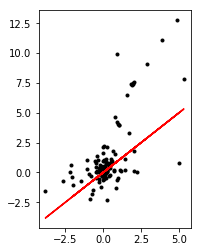

In [48]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - vb_opt, best_param_phi_pred - vb_opt, 'k.')
plt.plot(best_param_phi - vb_opt, best_param_phi - vb_opt, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [52]:
print('original expected number of clusters: ', 
      gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_opt,
                                    n_obs = np.shape(features)[0], 
                                    threshold = 0,
                                    n_samples = 100000))

original expected number of clusters:  6.644572534278998


In [54]:
print('perturbed expected number of clusters: ', 
      gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    best_param_phi,
                                    n_obs = np.shape(features)[0], 
                                    threshold = 0,
                                    n_samples = 100000))

perturbed expected number of clusters:  4.789143972324354


In [58]:
print('predicted expected number of clusters: ', 
      gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    best_param_phi_pred,
                                    n_obs = np.shape(features)[0], 
                                    threshold = 0,
                                    n_samples = 10000))

predicted expected number of clusters:  1.9506230637272128


/home/runjing_liu/Documents/BNP/autograd/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


# Predict for a range of perturbations

In [59]:
# epsilon_vec = np.arange(, 15)
epsilon_vec = np.linspace(0.1, 1, 10)
print(epsilon_vec)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [60]:
best_param_phi_array = []
best_param_phi_pred_array = []

In [64]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    epsilon_param_dict['epsilon'] = epsilon
    best_param_phi_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon_param_dict, fold_output = False)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - vb_opt))
    
    # Then fit with the perturbation.
    get_perturbed_vb_loss = paragami.Functor(
    original_fun=get_perturbed_kl, argnums=[1])
    
    get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, log_phi, 
                         prior_params_dict, gh_loc, gh_weights, prior_perturbation)
    get_perturb_vb_free_params_loss = paragami.FlattenedFunction(
                                                original_fun=get_perturbed_vb_loss,
                                                patterns=vb_params_paragami,
                                                free=True)

    pert_opt = gmm_lib.run_bfgs(get_perturb_vb_free_params_loss, 
                                    vb_opt, maxiter = 500)

#     print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - vb_opt))
    
    # save results: 
    best_param_phi_array.append(pert_opt[0])
    best_param_phi_pred_array.append(best_param_phi_pred)
    


Epsilon:  0.1
Predicted differences:  3.1941833957847665
         Current function value: -305.646013
         Iterations: 86
         Function evaluations: 147
         Gradient evaluations: 137
This is nonzero if phi did anything: 14.35689201895497
Epsilon:  0.2
Predicted differences:  6.388366791569532
         Current function value: -322.633675
         Iterations: 173
         Function evaluations: 277
         Gradient evaluations: 265
This is nonzero if phi did anything: 14.35689201895497
Epsilon:  0.30000000000000004
Predicted differences:  9.582550187354297
         Current function value: -317.471881
         Iterations: 167
         Function evaluations: 208
         Gradient evaluations: 206
This is nonzero if phi did anything: 14.35689201895497
Epsilon:  0.4
Predicted differences:  12.776733583139066
         Current function value: -313.090040
         Iterations: 157
         Function evaluations: 236
         Gradient evaluations: 224
This is nonzero if phi did anythin

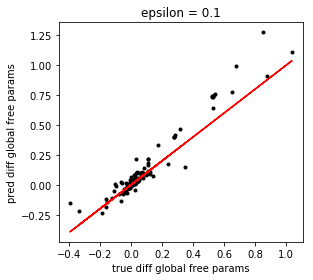

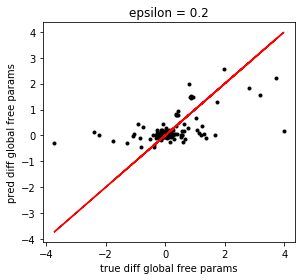

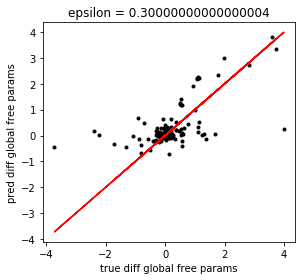

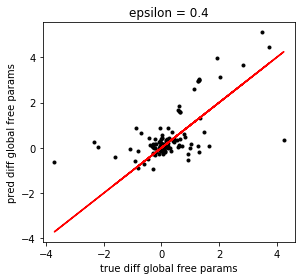

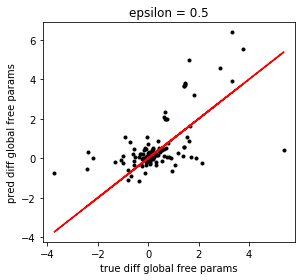

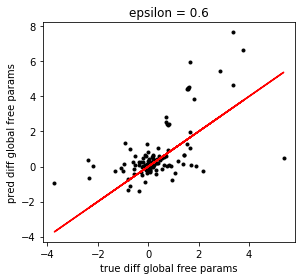

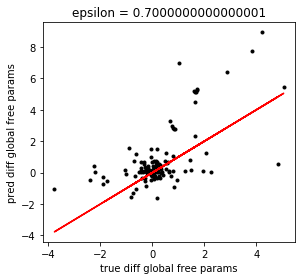

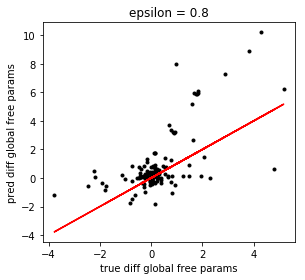

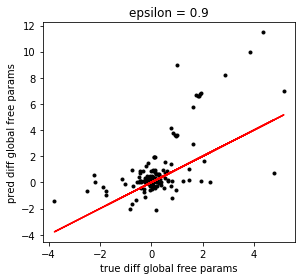

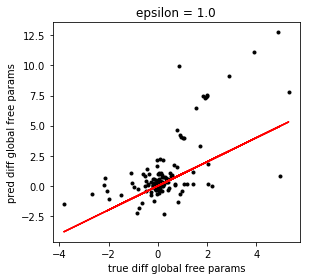

In [65]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - vb_opt, 
             best_param_phi_pred_array[i] - vb_opt, 'k.')
    plt.plot(best_param_phi_array[i] - vb_opt, 
             best_param_phi_array[i] - vb_opt, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [69]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in range(len(epsilon_vec)): 
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    best_param_phi_pred_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    best_param_phi_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters

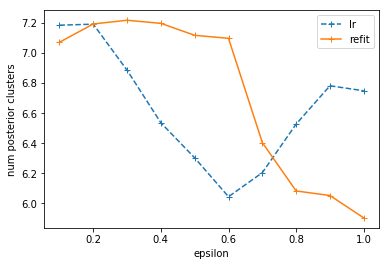

In [71]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
